## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [1]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

## Loading the dataset

In [2]:
# mount to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import the training dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Train.csv')

In [4]:
# import the test dataset
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Test.csv')

In [5]:
# make a copy of the training dataset
copy = data.copy()

In [6]:
# make a copy of the test dataset
test_copy = test_data.copy()

## Data Overview

- Observations
- Sanity checks

### View the first & last 5 rows

In [7]:
# view first 5 rows of training data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [8]:
# view first 5 rows of test data
test_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


In [9]:
# view last 5 rows of training data
data.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
19995,-2.071,-1.088,-0.796,-3.012,-2.288,2.807,0.481,0.105,-0.587,-2.899,8.868,1.717,1.358,-1.777,0.710,4.945,-3.100,-1.199,-1.085,-0.365,3.131,-3.948,-3.578,-8.139,-1.937,-1.328,-0.403,-1.735,9.996,6.955,-3.938,-8.274,5.745,0.589,-0.650,-3.043,2.216,0.609,0.178,2.928,1
19996,2.890,2.483,5.644,0.937,-1.381,0.412,-1.593,-5.762,2.150,0.272,-2.095,-1.526,0.072,-3.540,-2.762,-10.632,-0.495,1.720,3.872,-1.210,-8.222,2.121,-5.492,1.452,1.450,3.685,1.077,-0.384,-0.839,-0.748,-1.089,-4.159,1.181,-0.742,5.369,-0.693,-1.669,3.660,0.820,-1.987,0
19997,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
19998,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
19999,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0


In [10]:
# view the last 5 rows of test data
test_data.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
4995,-5.120,1.635,1.251,4.036,3.291,-2.932,-1.329,1.754,-2.985,1.249,-6.878,3.715,-2.512,-1.395,-2.554,-2.197,4.772,2.403,3.792,0.487,-2.028,1.778,3.668,11.375,-1.977,2.252,-7.319,1.907,-3.734,-0.012,2.120,9.979,0.063,0.217,3.036,2.109,-0.557,1.939,0.513,-2.694,0
4996,-5.172,1.172,1.579,1.220,2.530,-0.669,-2.618,-2.001,0.634,-0.579,-3.671,0.460,3.321,-1.075,-7.113,-4.356,-0.001,3.698,-0.846,-0.222,-3.645,0.736,0.926,3.278,-2.277,4.458,-4.543,-1.348,-1.779,0.352,-0.214,4.424,2.604,-2.152,0.917,2.157,0.467,0.470,2.197,-2.377,0
4997,-1.114,-0.404,-1.765,-5.879,3.572,3.711,-2.483,-0.308,-0.922,-2.999,-0.112,-1.977,-1.623,-0.945,-2.735,-0.813,0.610,8.149,-9.199,-3.872,-0.296,1.468,2.884,2.792,-1.136,1.198,-4.342,-2.869,4.124,4.197,3.471,3.792,7.482,-10.061,-0.387,1.849,1.818,-1.246,-1.261,7.475,0
4998,-1.703,0.615,6.221,-0.104,0.956,-3.279,-1.634,-0.104,1.388,-1.066,-7.970,2.262,3.134,-0.486,-3.498,-4.562,3.136,2.536,-0.792,4.398,-4.073,-0.038,-2.371,-1.542,2.908,3.215,-0.169,-1.541,-4.724,-5.525,1.668,-4.100,-5.949,0.550,-1.574,6.824,2.139,-4.036,3.436,0.579,0
4999,-0.604,0.960,-0.721,8.230,-1.816,-2.276,-2.575,-1.041,4.130,-2.731,-3.292,-1.674,0.465,-1.646,-5.263,-7.988,6.480,0.226,4.963,6.752,-6.306,3.271,1.897,3.271,-0.637,-0.925,-6.759,2.990,-0.814,3.499,-8.435,2.370,-1.062,0.791,4.952,-7.441,-0.070,-0.918,-2.291,-5.363,0


In [11]:
# understand the shape of the training data
data.shape

(20000, 41)

In [12]:
# understand the shape of the test data
test_data.shape

(5000, 41)

Observation: Our training dataset has 20,000 observations and our test dataset has 5,000.

In [13]:
# check the data types for the training data columns 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [14]:
# check the data types for the test data columns 
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

Observations: 
* We can see that the V1 and V2 columns have less than 20,000 non-null values in the training dataset i.e. column have missing values. We'll explore this further. There are also some missing values in those columns in the test dataset.

In [15]:
# statistical summary of dataset
data.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


Observations: We can see that some of the sensors give off negative values. Since there are many of them, we will assume that the data is correct.

In [16]:
# let's check for duplicate values in the training data
data.duplicated().sum()

0

In [17]:
# let's check for duplicate values in the test data
test_data.duplicated().sum()

0

Observation: We have no duplicates.

In [18]:
# let's check for missing values in the training data
round(data.isnull().sum() / data.isnull().count() * 100, 2)

V1       0.090
V2       0.090
V3       0.000
V4       0.000
V5       0.000
V6       0.000
V7       0.000
V8       0.000
V9       0.000
V10      0.000
V11      0.000
V12      0.000
V13      0.000
V14      0.000
V15      0.000
V16      0.000
V17      0.000
V18      0.000
V19      0.000
V20      0.000
V21      0.000
V22      0.000
V23      0.000
V24      0.000
V25      0.000
V26      0.000
V27      0.000
V28      0.000
V29      0.000
V30      0.000
V31      0.000
V32      0.000
V33      0.000
V34      0.000
V35      0.000
V36      0.000
V37      0.000
V38      0.000
V39      0.000
V40      0.000
Target   0.000
dtype: float64

In [19]:
# let's check for missing values in the test data
round(test_data.isnull().sum() / test_data.isnull().count() * 100, 2)

V1       0.100
V2       0.120
V3       0.000
V4       0.000
V5       0.000
V6       0.000
V7       0.000
V8       0.000
V9       0.000
V10      0.000
V11      0.000
V12      0.000
V13      0.000
V14      0.000
V15      0.000
V16      0.000
V17      0.000
V18      0.000
V19      0.000
V20      0.000
V21      0.000
V22      0.000
V23      0.000
V24      0.000
V25      0.000
V26      0.000
V27      0.000
V28      0.000
V29      0.000
V30      0.000
V31      0.000
V32      0.000
V33      0.000
V34      0.000
V35      0.000
V36      0.000
V37      0.000
V38      0.000
V39      0.000
V40      0.000
Target   0.000
dtype: float64

Observation: We can see columns V1 & V2 have less than 1% missing values in the training data and around 1% in the test data. We will impute them later.

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [20]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

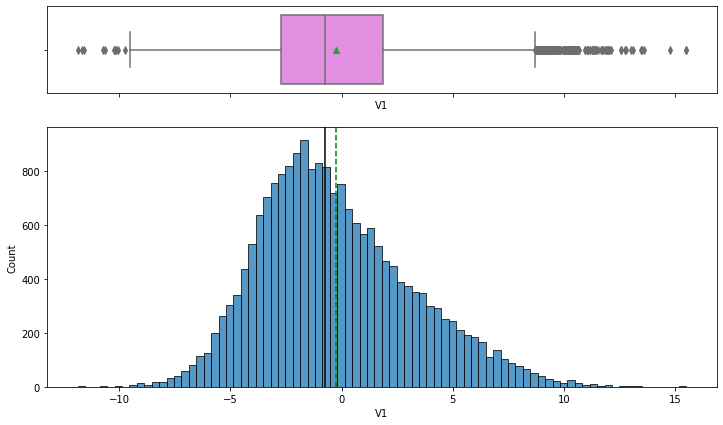

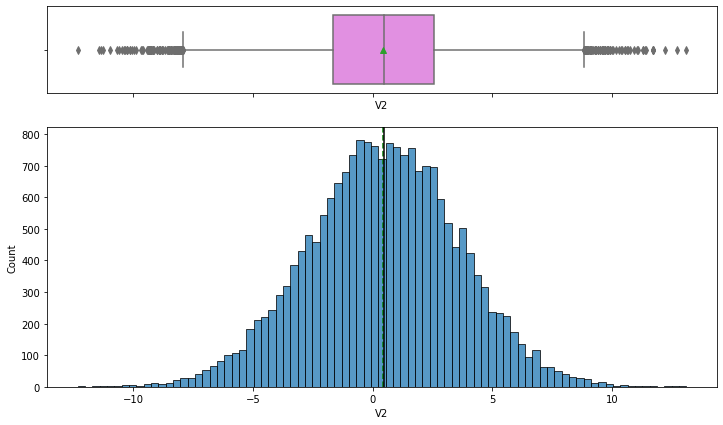

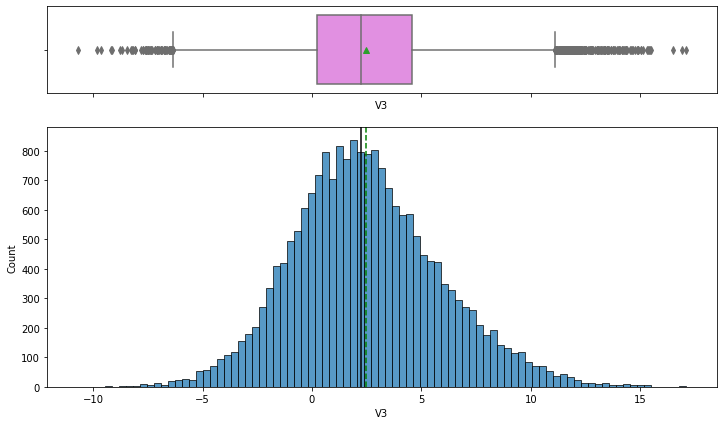

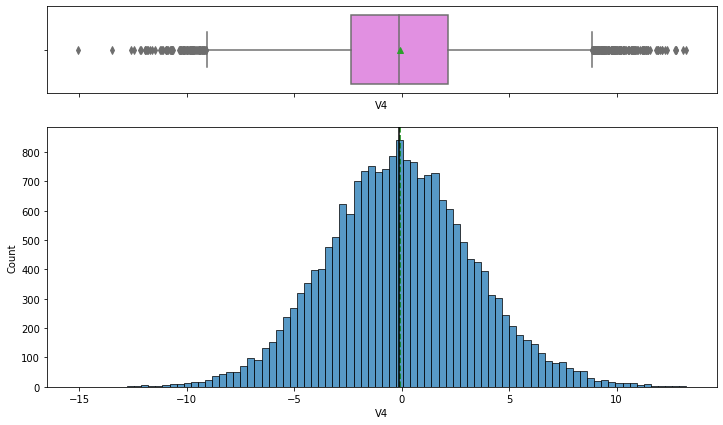

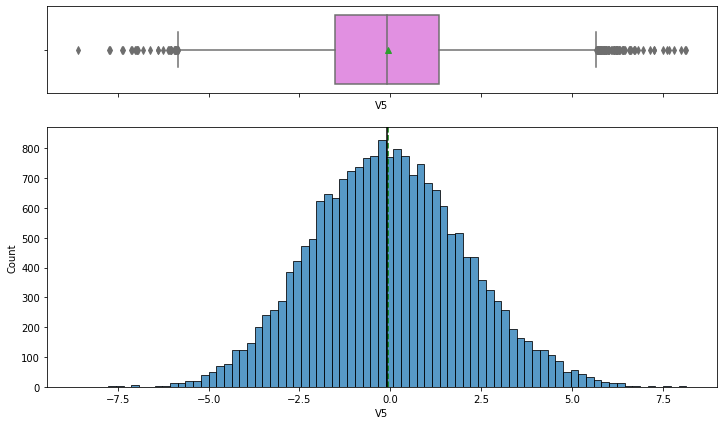

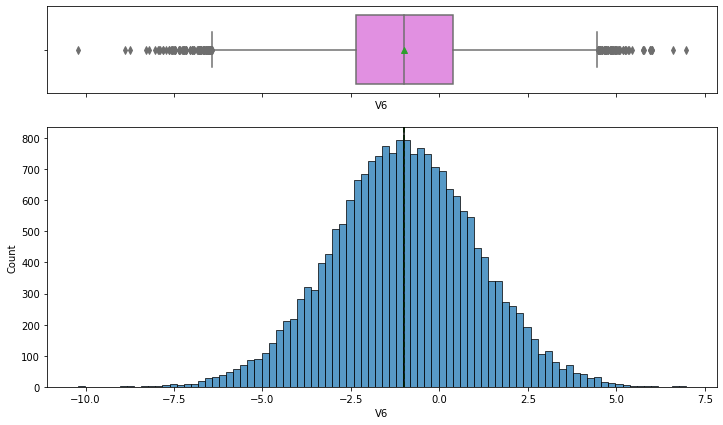

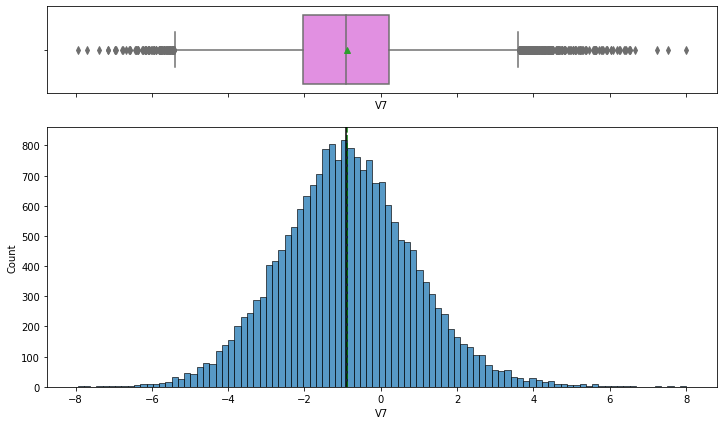

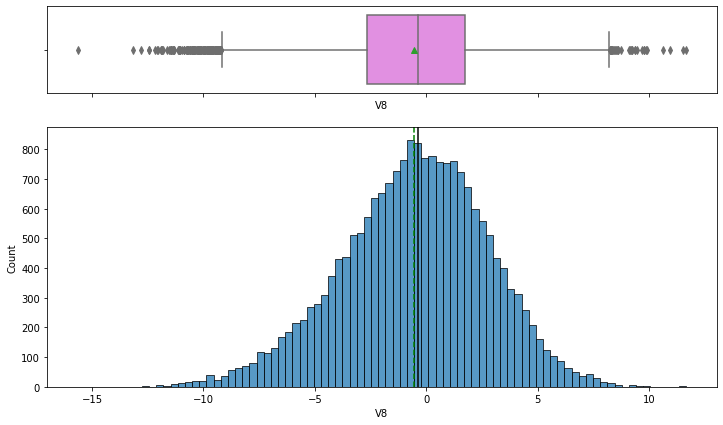

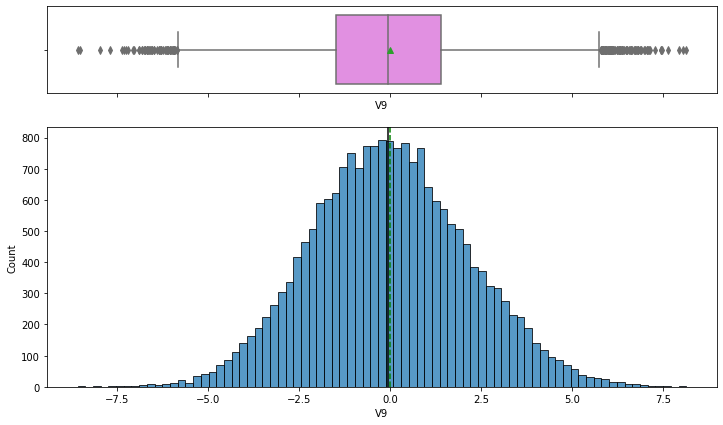

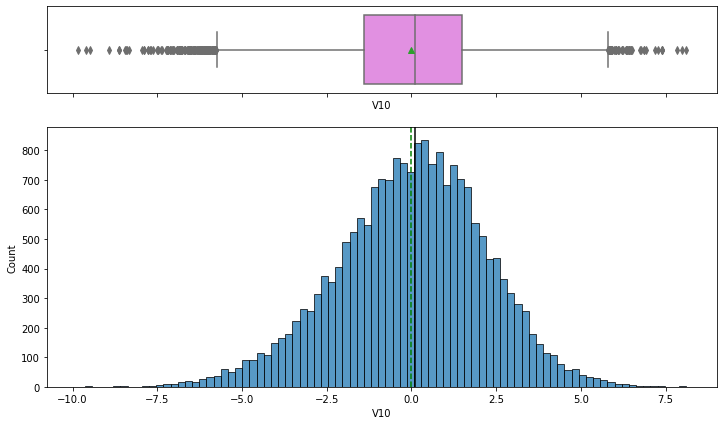

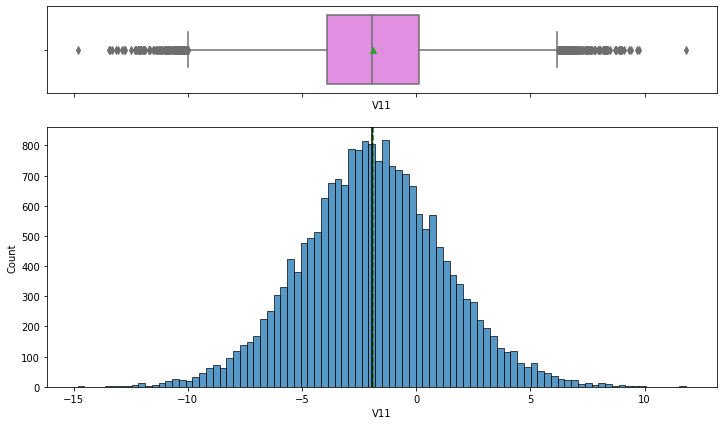

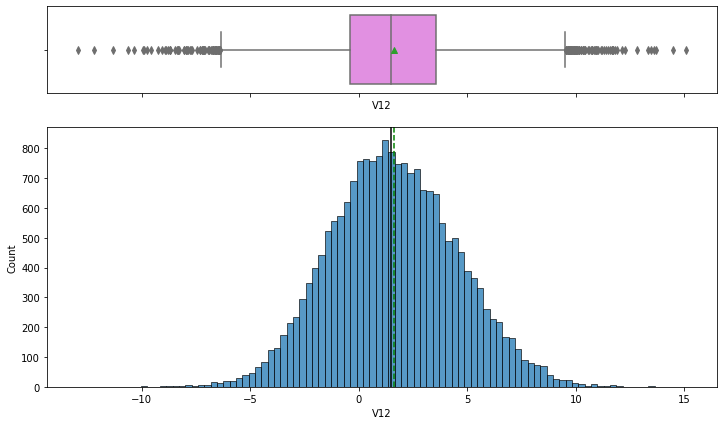

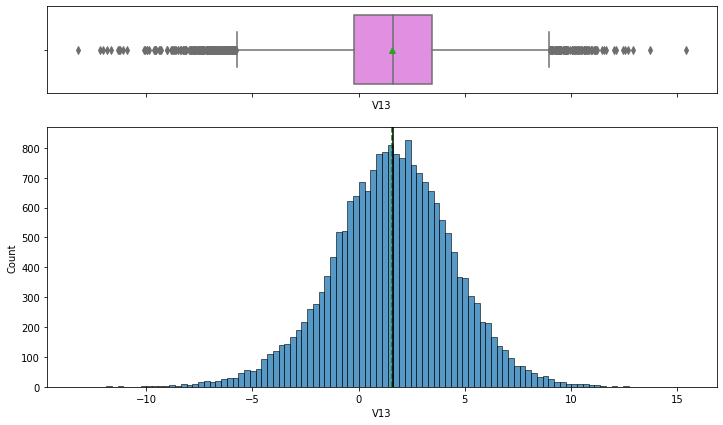

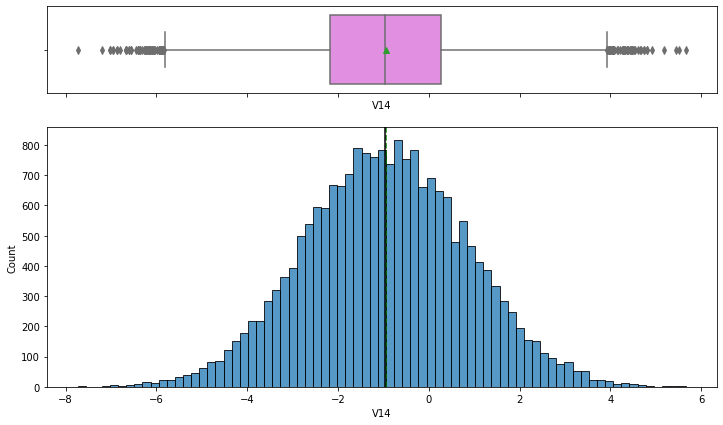

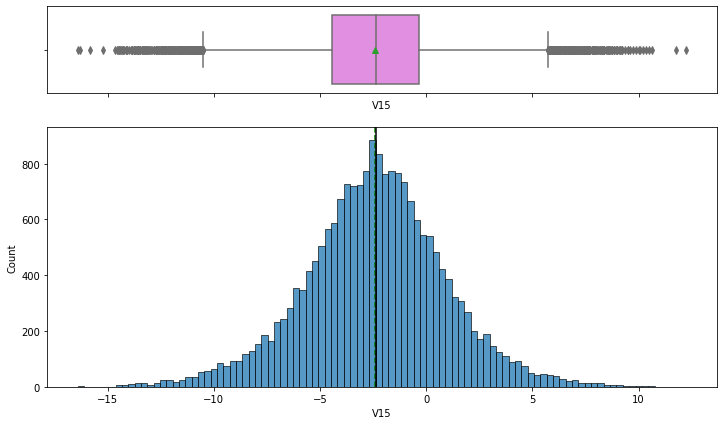

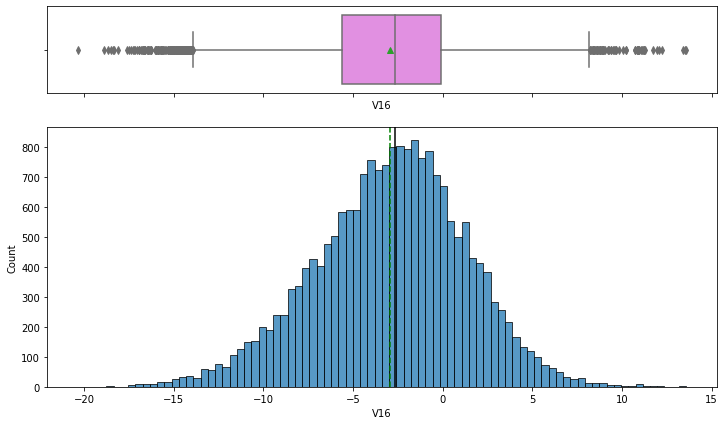

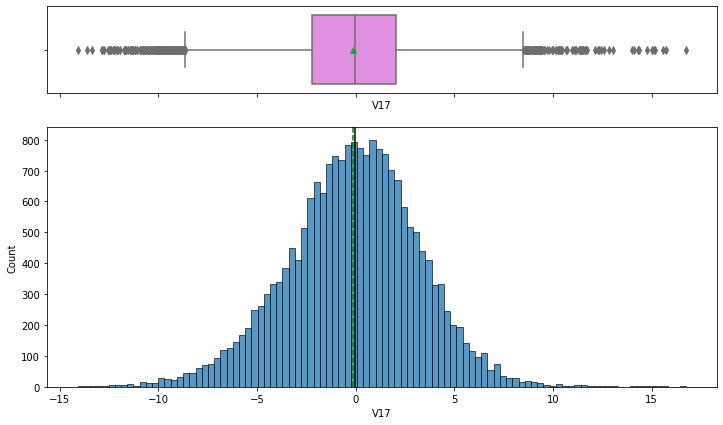

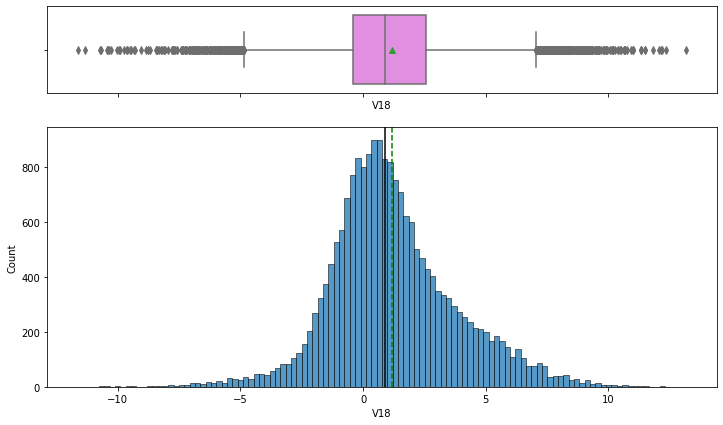

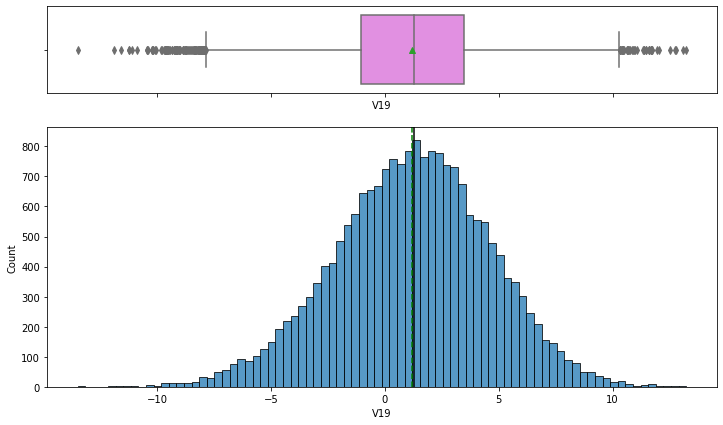

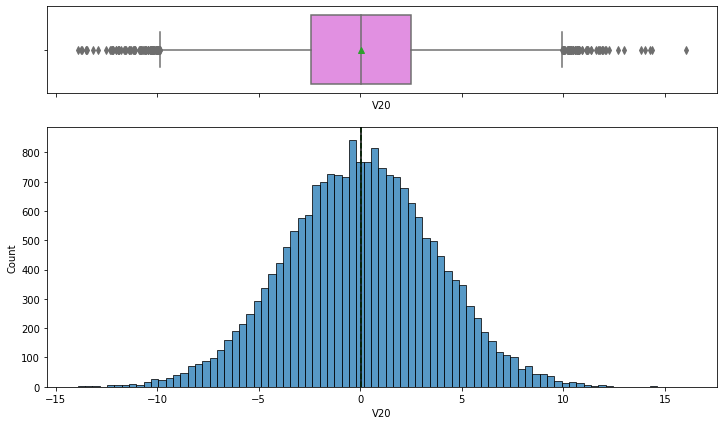

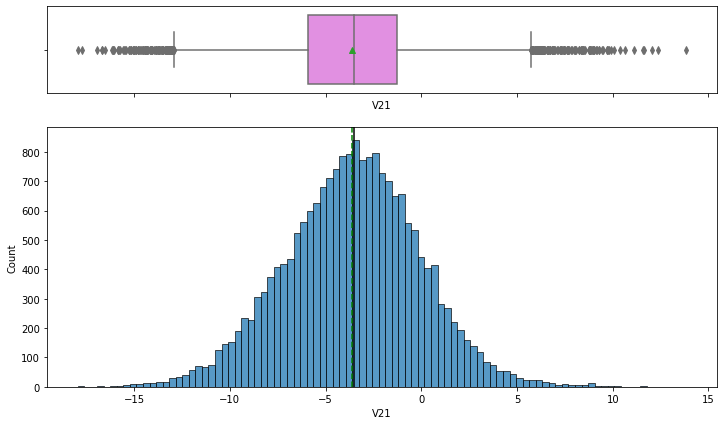

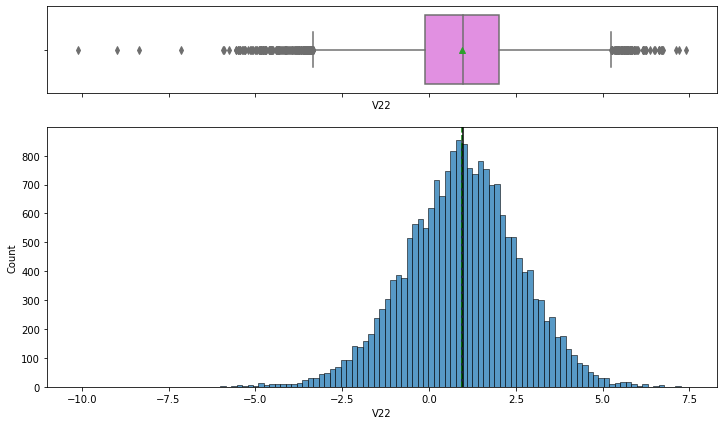

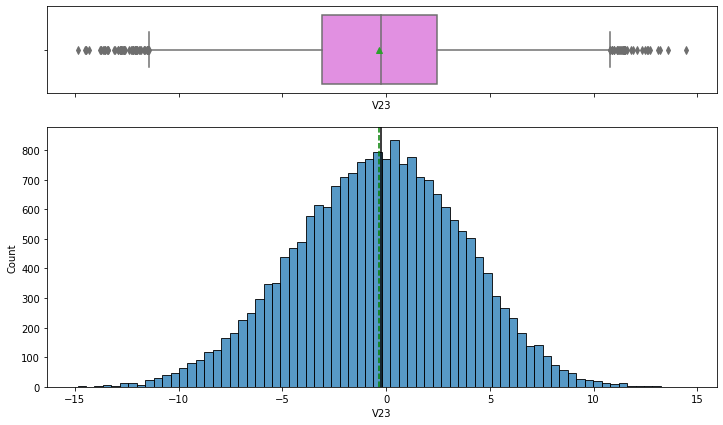

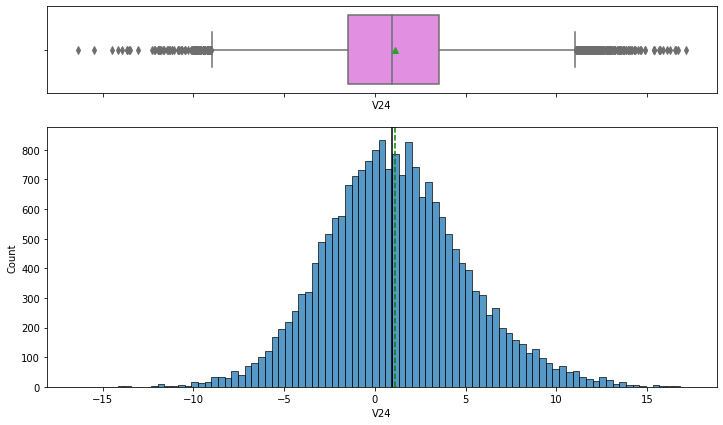

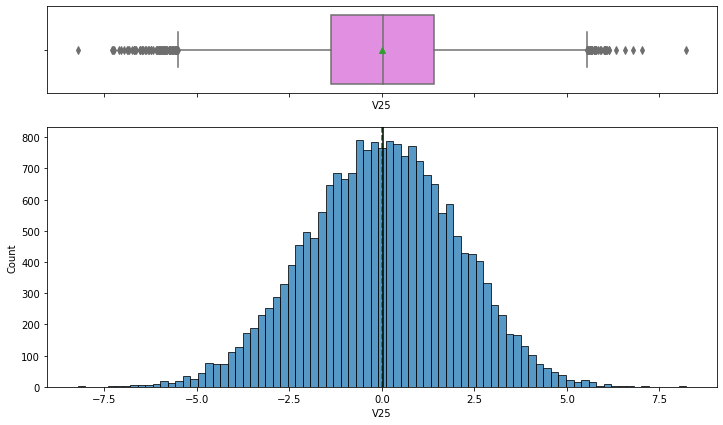

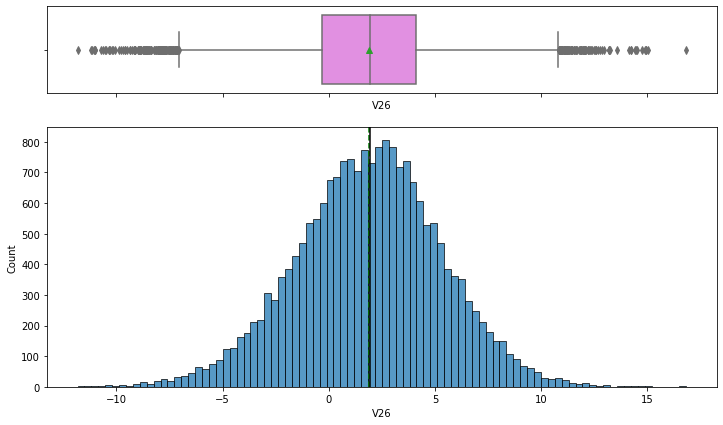

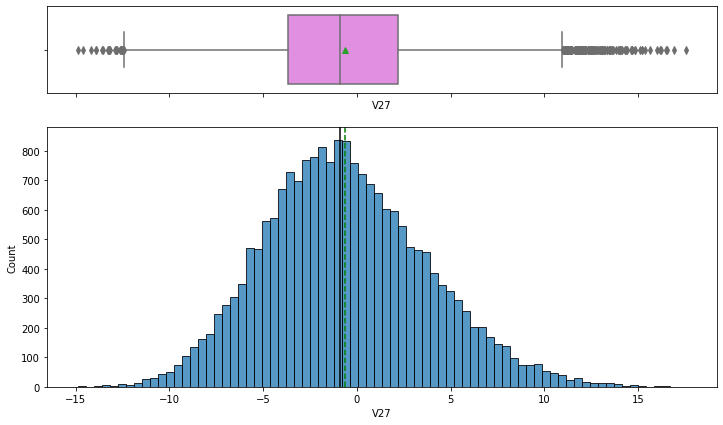

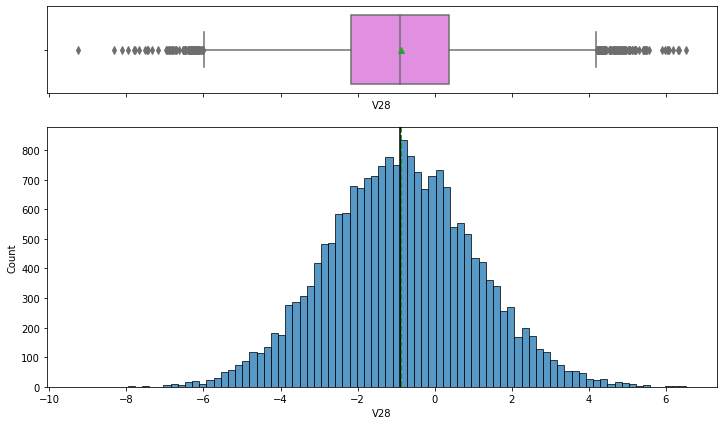

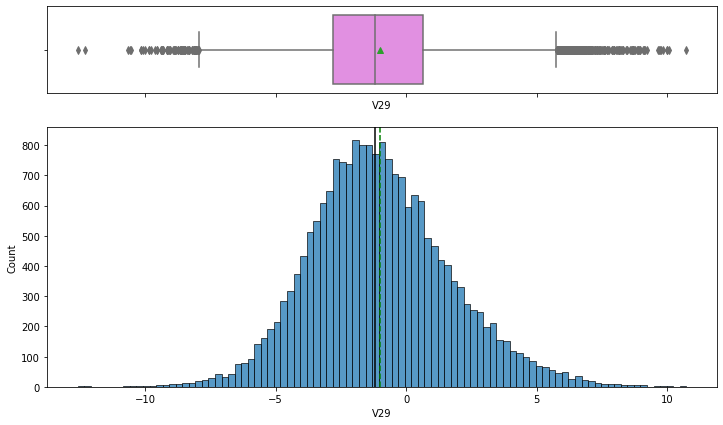

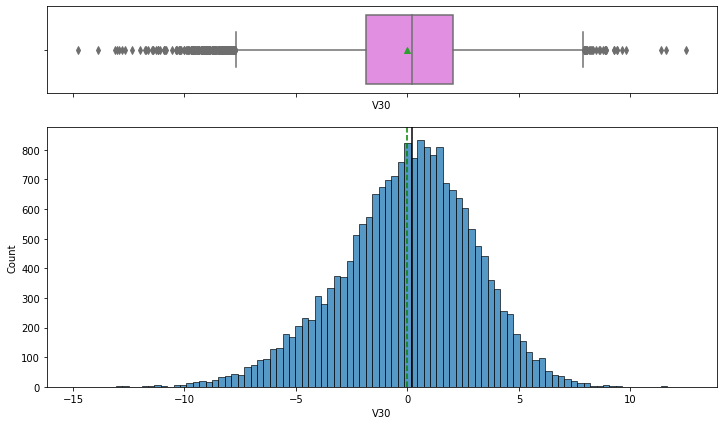

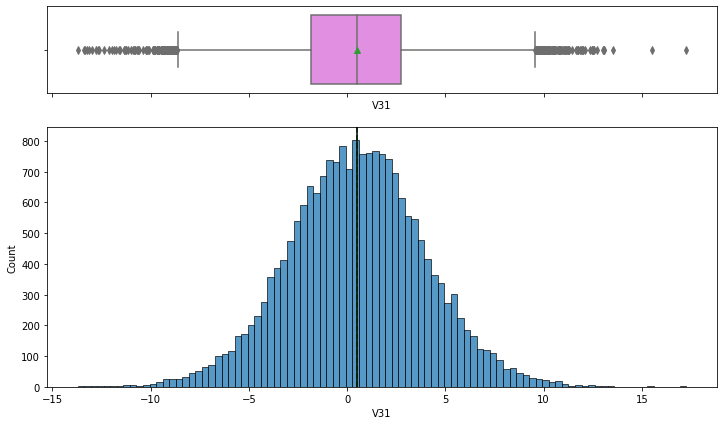

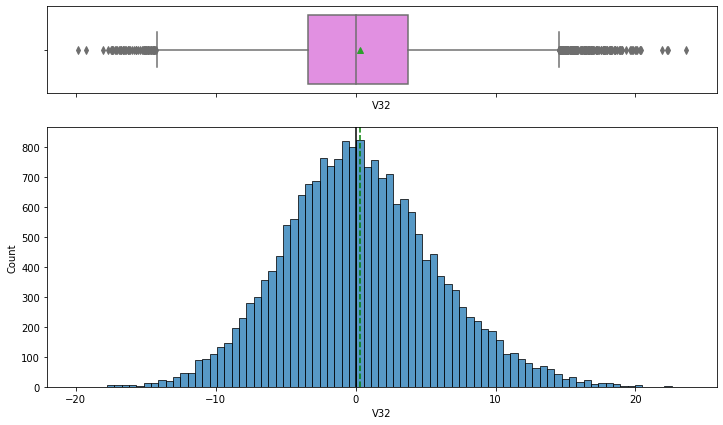

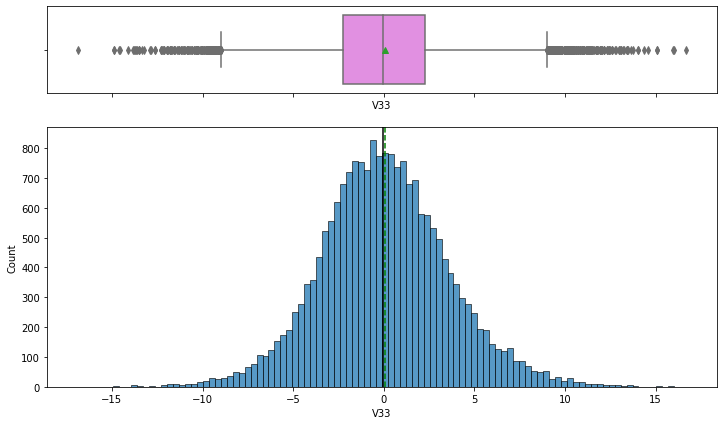

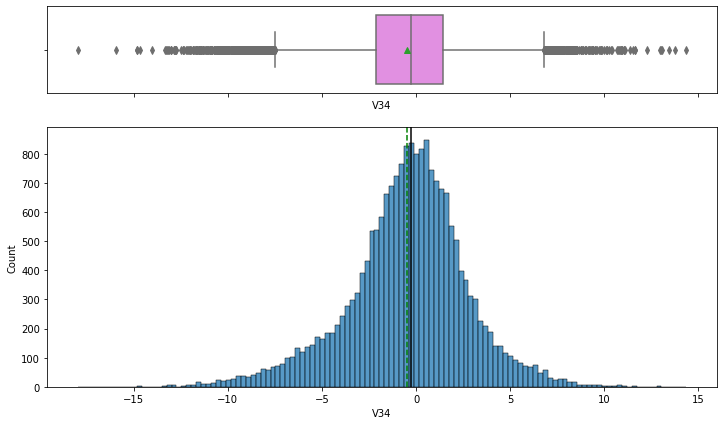

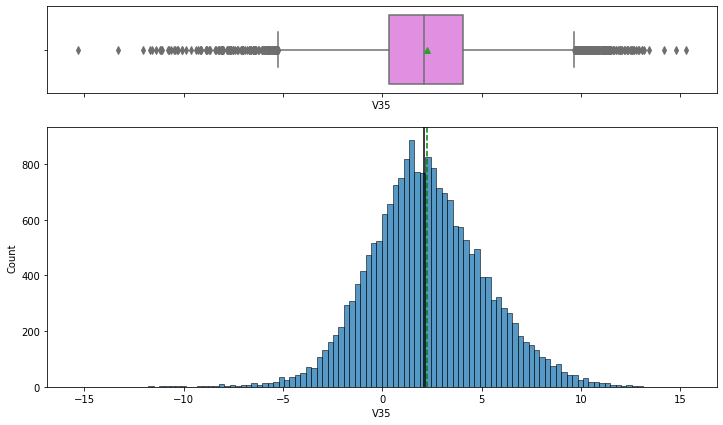

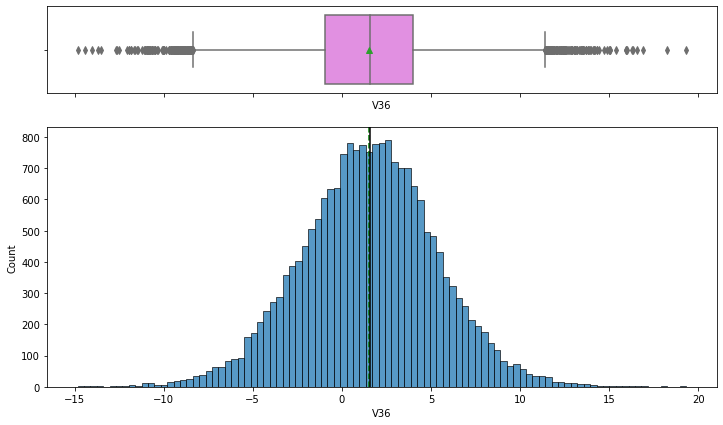

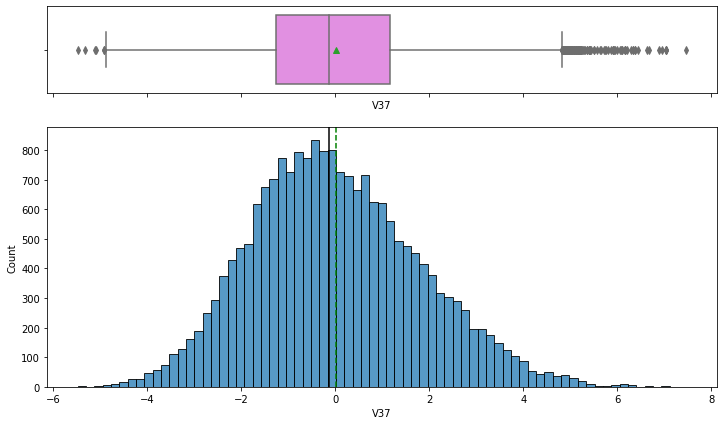

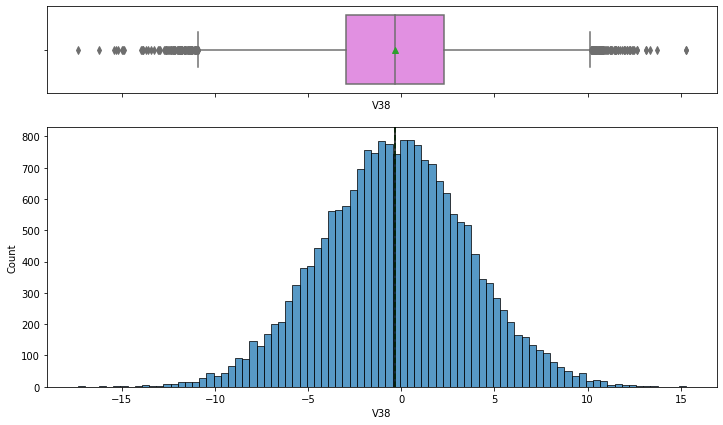

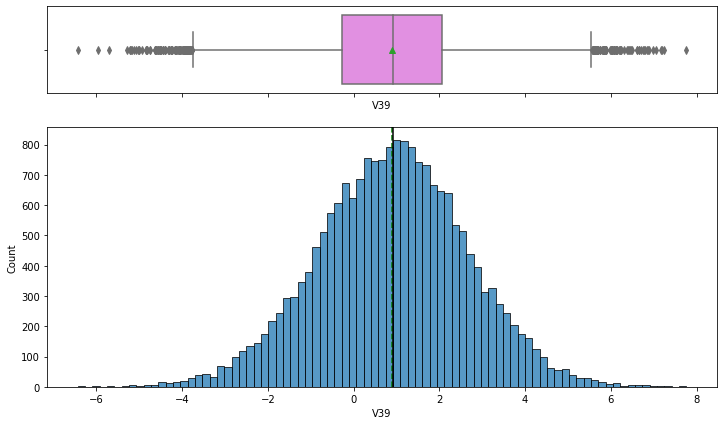

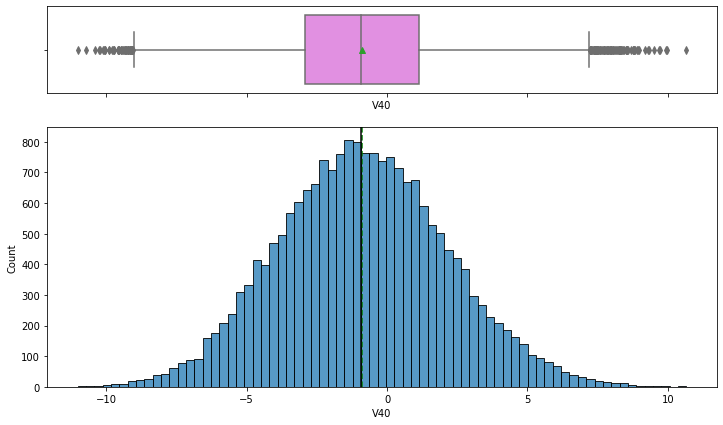

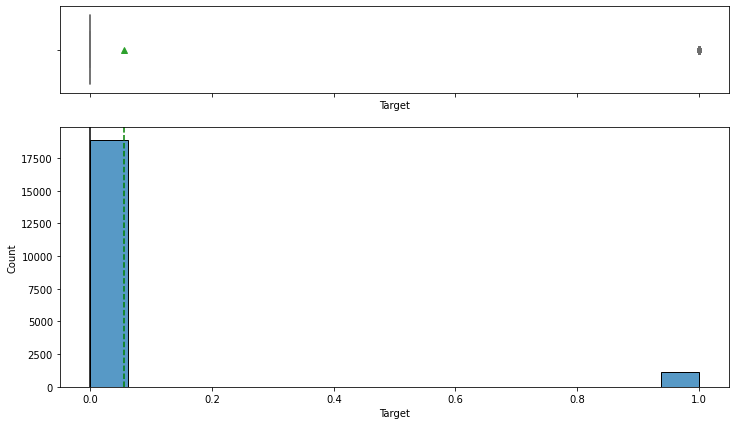

In [21]:
for feature in data.columns:
    histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None)

### Check distribution of target variable

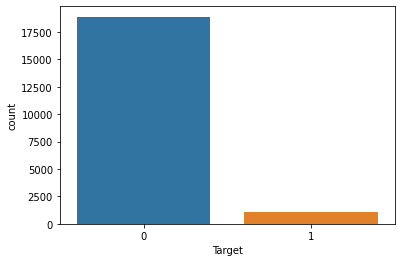

In [22]:
# visualize target variable for training data
sns.countplot(data=data, x='Target');

In [23]:
# get target variable counts for training data
data['Target'].value_counts()

0    18890
1     1110
Name: Target, dtype: int64

In [24]:
# get target variable distribution for training data
data['Target'].value_counts(normalize="True")

0   0.945
1   0.056
Name: Target, dtype: float64

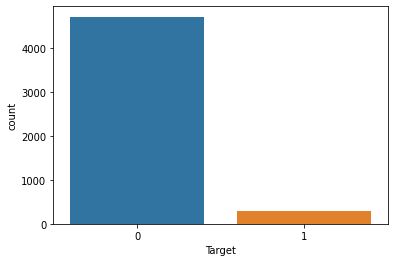

In [25]:
# visualize target variable for test data
sns.countplot(data=test_data, x='Target');

In [26]:
# get target variable counts for test data
test_data['Target'].value_counts()

0    4718
1     282
Name: Target, dtype: int64

In [27]:
# get target variable distribution for test data
test_data['Target'].value_counts(normalize="True")

0   0.944
1   0.056
Name: Target, dtype: float64

Observation: We see the same distribution for the Target in both the trian & test datasets. We have imbalanced classes since 1, or failure, happens much less than no failure.

## Data Pre-processing

Note: We will be imputing the missing values in the data after splitting train into train and validation to avoid data leakage.

In [28]:
# make another copy of the training dataset
df = data.copy()

In [29]:
# Separating target variable and other variables
X = df.drop(['Target'], axis=1)
y = df['Target']

In [30]:
# Split the training dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)
print(X_train.shape, X_val.shape)

(15000, 40) (5000, 40)


In [31]:
# make another copy of the test dataset
df_test = test_data.copy()

In [32]:
# Separating target variable and other variables in the test set
X_test = df_test.drop(['Target'], axis=1)
y_test = df_test['Target']

In [33]:
# verifying the shape of the test set
X_test.shape

(5000, 40)

## Missing value imputation




In [34]:
# using median as standard imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy = "median")

In [35]:
# Fit and transform the training data
X_train["V1"] = imp_median.fit_transform(X_train[["V1"]])
X_train["V2"] = imp_median.fit_transform(X_train[["V2"]])

In [36]:
# Transform the validation & test data using the imputer fit on training data
X_val["V1"] = imp_median.fit_transform(X_val[["V1"]])
X_val["V2"] = imp_median.fit_transform(X_val[["V2"]])

X_test["V1"] = imp_median.fit_transform(X_test[["V1"]])
X_test["V2"] = imp_median.fit_transform(X_test[["V2"]])

In [37]:
# Make sure missing values have been fixed on training data
round(X_train.isnull().sum() / X_train.isnull().count() * 100, 2)

V1    0.000
V2    0.000
V3    0.000
V4    0.000
V5    0.000
V6    0.000
V7    0.000
V8    0.000
V9    0.000
V10   0.000
V11   0.000
V12   0.000
V13   0.000
V14   0.000
V15   0.000
V16   0.000
V17   0.000
V18   0.000
V19   0.000
V20   0.000
V21   0.000
V22   0.000
V23   0.000
V24   0.000
V25   0.000
V26   0.000
V27   0.000
V28   0.000
V29   0.000
V30   0.000
V31   0.000
V32   0.000
V33   0.000
V34   0.000
V35   0.000
V36   0.000
V37   0.000
V38   0.000
V39   0.000
V40   0.000
dtype: float64

In [38]:
# Make sure missing values have been fixed on validation data
round(X_val.isnull().sum() / X_val.isnull().count() * 100, 2)

V1    0.000
V2    0.000
V3    0.000
V4    0.000
V5    0.000
V6    0.000
V7    0.000
V8    0.000
V9    0.000
V10   0.000
V11   0.000
V12   0.000
V13   0.000
V14   0.000
V15   0.000
V16   0.000
V17   0.000
V18   0.000
V19   0.000
V20   0.000
V21   0.000
V22   0.000
V23   0.000
V24   0.000
V25   0.000
V26   0.000
V27   0.000
V28   0.000
V29   0.000
V30   0.000
V31   0.000
V32   0.000
V33   0.000
V34   0.000
V35   0.000
V36   0.000
V37   0.000
V38   0.000
V39   0.000
V40   0.000
dtype: float64

In [39]:
# Make sure missing values have been fixed on test data
round(X_test.isnull().sum() / X_test.isnull().count() * 100, 2)

V1    0.000
V2    0.000
V3    0.000
V4    0.000
V5    0.000
V6    0.000
V7    0.000
V8    0.000
V9    0.000
V10   0.000
V11   0.000
V12   0.000
V13   0.000
V14   0.000
V15   0.000
V16   0.000
V17   0.000
V18   0.000
V19   0.000
V20   0.000
V21   0.000
V22   0.000
V23   0.000
V24   0.000
V25   0.000
V26   0.000
V27   0.000
V28   0.000
V29   0.000
V30   0.000
V31   0.000
V32   0.000
V33   0.000
V34   0.000
V35   0.000
V36   0.000
V37   0.000
V38   0.000
V39   0.000
V40   0.000
dtype: float64

Observation: All missing values have been dealt with.

In [40]:
# Checking class balance for whole data, train set, validation set, and test set
print("Target value ratio in y")
print(y.value_counts(1))
print("*" * 80)
print("Target value ratio in y_train")
print(y_train.value_counts(1))
print("*" * 80)
print("Target value ratio in y_val")
print(y_val.value_counts(1))
print("*" * 80)
print("Target value ratio in y_test")
print(y_test.value_counts(1))
print("*" * 80)

Target value ratio in y
0   0.945
1   0.056
Name: Target, dtype: float64
********************************************************************************
Target value ratio in y_train
0   0.945
1   0.055
Name: Target, dtype: float64
********************************************************************************
Target value ratio in y_val
0   0.944
1   0.056
Name: Target, dtype: float64
********************************************************************************
Target value ratio in y_test
0   0.944
1   0.056
Name: Target, dtype: float64
********************************************************************************


Observation: Classes are imbalanced, but the imbalance is consistent across the training, validation, & testing sets.

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [41]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [42]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

In [43]:
%%time

models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Dtree", DecisionTreeClassifier(random_state=1)))
models.append(("LogRegression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("RandomForest", RandomForestClassifier(random_state=1)))
models.append(("AdaBoost", AdaBoostClassifier(random_state=1)))
models.append(("GradientBoost", GradientBoostingClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Dtree: 0.6982829521679532
LogRegression: 0.4927566553639709
Bagging: 0.7210807301060529
RandomForest: 0.7235192266070268
AdaBoost: 0.6309140754635308
GradientBoost: 0.7066661857008874

Validation Performance:

Dtree: 0.7050359712230215
LogRegression: 0.48201438848920863
Bagging: 0.7302158273381295
RandomForest: 0.7266187050359713
AdaBoost: 0.6762589928057554
GradientBoost: 0.7230215827338129
CPU times: user 5min 21s, sys: 910 ms, total: 5min 22s
Wall time: 5min 27s


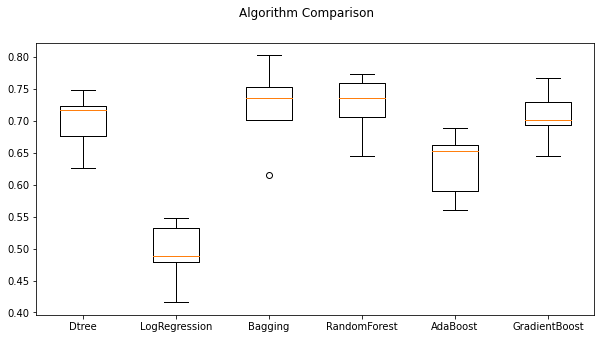

In [44]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 5))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

Observations: The model does not seem to be overfit on the training data, so that is good! The Bagging classifier & Random Forest models seem to be the best so far. But I think we can get better performance - let's try over sampling...

### Model Building with Oversampled data


In [45]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [46]:
# Comparing the class imbalance pre & post oversampling
print("Before Over Sampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Over Sampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print("After Over Sampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After Over Sampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After Over Sampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Over Sampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Over Sampling, counts of label '1': 832
Before Over Sampling, counts of label '0': 14168 

After Over Sampling, counts of label '1': 14168
After Over Sampling, counts of label '0': 14168 

After Over Sampling, the shape of train_X: (28336, 40)
After Over Sampling, the shape of train_y: (28336,) 



Observation: We can see that the classes are balanced now since we used SMOTE to create new '1's.

In [47]:
%%time

models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Dtree_over", DecisionTreeClassifier(random_state=1)))
models.append(("LogRegression_over", LogisticRegression(random_state=1)))
models.append(("Bagging_over", BaggingClassifier(random_state=1)))
models.append(("RandomForest_over", RandomForestClassifier(random_state=1)))
models.append(("AdaBoost_over", AdaBoostClassifier(random_state=1)))
models.append(("GradientBoost_over", GradientBoostingClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over,y_train_over) 
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Dtree_over: 0.9720494245534969
LogRegression_over: 0.883963699328486
Bagging_over: 0.9762141471581656
RandomForest_over: 0.9839075260047615
AdaBoost_over: 0.8978689011775473
GradientBoost_over: 0.9256068151319724

Validation Performance:

Dtree_over: 0.7769784172661871
LogRegression_over: 0.8489208633093526
Bagging_over: 0.8345323741007195
RandomForest_over: 0.8489208633093526
AdaBoost_over: 0.8561151079136691
GradientBoost_over: 0.8776978417266187
CPU times: user 9min 29s, sys: 1.9 s, total: 9min 31s
Wall time: 10min 14s


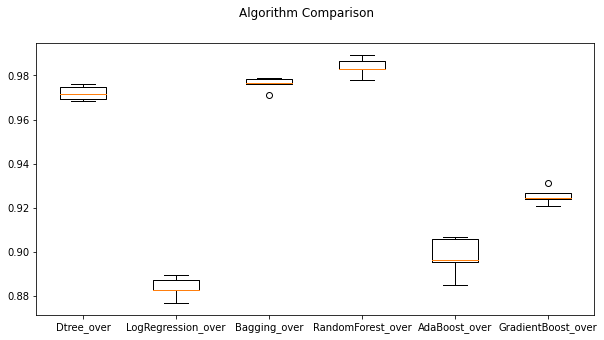

In [48]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 5))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

Observation: We're seeing better performance, but several models seem to now be overfitting on the training data - ie: Dtree, Bagging classifier, etc. Let's see if we can take care of the overfit problem with under sampling.

### Model Building with Undersampled data

In [49]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [50]:
# Comparing the class imbalance pre & post undersampling
print("Before Under Sampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Under Sampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After Under Sampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, counts of label '1': 832
Before Under Sampling, counts of label '0': 14168 

After Under Sampling, counts of label '1': 832
After Under Sampling, counts of label '0': 832 

After Under Sampling, the shape of train_X: (1664, 40)
After Under Sampling, the shape of train_y: (1664,) 



Observation: Are classes are now balanced, but this time by removing '0' labels so we have an equal number.

In [51]:
%%time

models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Dtree_under", DecisionTreeClassifier(random_state=1)))
models.append(("LogRegression_under", LogisticRegression(random_state=1)))
models.append(("Bagging_under", BaggingClassifier(random_state=1)))
models.append(("RandomForest_under", RandomForestClassifier(random_state=1)))
models.append(("AdaBoost_under", AdaBoostClassifier(random_state=1)))
models.append(("GradientBoost_under", GradientBoostingClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un,y_train_un) 
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Dtree_under: 0.8617776495202367
LogRegression_under: 0.8726138085275232
Bagging_under: 0.8641945025611427
RandomForest_under: 0.9038669648654498
AdaBoost_under: 0.8666113556020489
GradientBoost_under: 0.8990621167303946

Validation Performance:

Dtree_under: 0.841726618705036
LogRegression_under: 0.8525179856115108
Bagging_under: 0.8705035971223022
RandomForest_under: 0.8920863309352518
AdaBoost_under: 0.8489208633093526
GradientBoost_under: 0.8884892086330936
CPU times: user 26.1 s, sys: 296 ms, total: 26.4 s
Wall time: 26.4 s


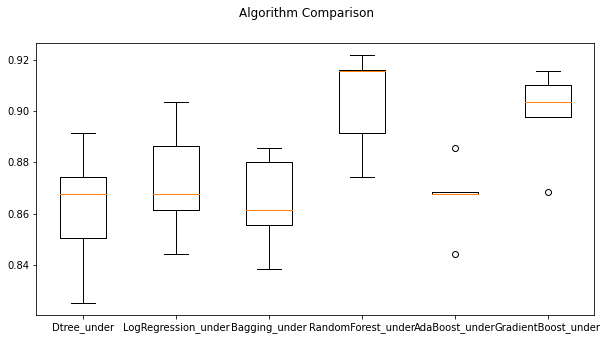

In [52]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 5))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

Observation: Looks like under sampling performed almost as well as over sampling for some models, and even better for others. It also solved our problem of overfit!

## HyperparameterTuning 

Let's tune the hyperparameters for 3 of our best performing models that are not suffering from overfit and see if we can further improve the performance. We will choose:
* AdaBoost Over Samping - .898 cross-val on training and .856 on validation
* Random Forest Under Sampling - .903 cross-val on training and .892 on validation
* Gradient Boost Under Sampling - .899 cross-val on training and .888 on validation

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Hyperparameter tuning for AdaBoost Classifier with oversampled data

In [53]:
%%time

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {"n_estimators": [100, 150, 200],
              "learning_rate": [0.2, 0.05], 
              "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1)]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9714853746337214:
CPU times: user 2min 12s, sys: 1.22 s, total: 2min 13s
Wall time: 31min 24s


In [54]:
# Creating new pipeline with best parameters
tuned_adaboost = AdaBoostClassifier(
    n_estimators= 200, learning_rate= 0.2, base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1)
)

tuned_adaboost.fit(X_train_over, y_train_over)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200)

In [55]:
# check performance on training set
adaboost_train_perf = model_performance_classification_sklearn(tuned_adaboost, X_train_over, y_train_over)
adaboost_train_perf

,Accuracy,Recall,Precision,F1
0,0.992,0.988,0.995,0.992


In [56]:
# check performance on validation set
adaboost_val_perf = model_performance_classification_sklearn(tuned_adaboost, X_val, y_val)
adaboost_val_perf

,Accuracy,Recall,Precision,F1
0,0.979,0.853,0.790,0.820


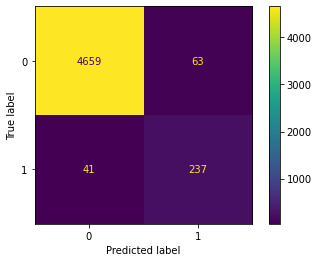

In [57]:
# print confusion matrix on validation set

predictions = tuned_adaboost.predict(X_val)
cm = confusion_matrix(y_val, predictions, labels=tuned_adaboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_adaboost.classes_)
disp.plot()
plt.show()

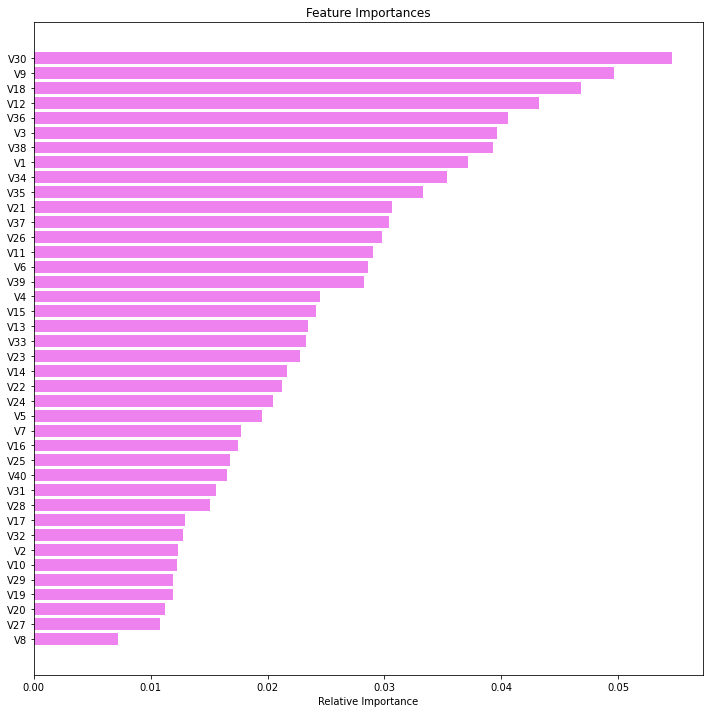

In [58]:
# print feature importance chart

importances = tuned_adaboost.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Observations: It appears our AdaBoost classifier on oversampled data is overfitting a bit on the training data. The recall score for the training set was 0.988 and the recall score for the validation set was 0.853.

The top feature (for this model) in understanding whether the turbine will fail is V30.

### Hyperparameter tuning for Random Forest model with undersampled data

In [59]:
%%time

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {"n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4), 
              "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
              "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.8978140105331505:
CPU times: user 2.24 s, sys: 43.3 ms, total: 2.28 s
Wall time: 46.6 s


In [60]:
# Creating new pipeline with best parameters
tuned_rf = RandomForestClassifier(
    n_estimators= 250, min_samples_leaf= 1, max_samples= 0.6, max_features= 'sqrt'
)

tuned_rf.fit(X_train_un, y_train_un)

RandomForestClassifier(max_samples=0.6, n_estimators=250)

In [61]:
# check performance on training set
rf_train_perf = model_performance_classification_sklearn(tuned_rf, X_train_un, y_train_un)
rf_train_perf

,Accuracy,Recall,Precision,F1
0,0.989,0.980,0.999,0.989


In [62]:
# check performance on validation set
rf_val_perf = model_performance_classification_sklearn(tuned_rf, X_val, y_val)
rf_val_perf

,Accuracy,Recall,Precision,F1
0,0.943,0.892,0.494,0.636


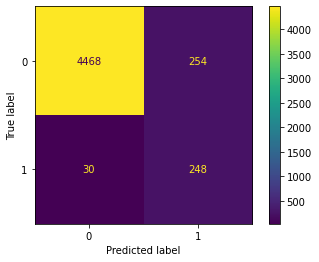

In [63]:
# print confusion matrix on validation set

predictions = tuned_rf.predict(X_val)
cm = confusion_matrix(y_val, predictions, labels=tuned_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_rf.classes_)
disp.plot()
plt.show()

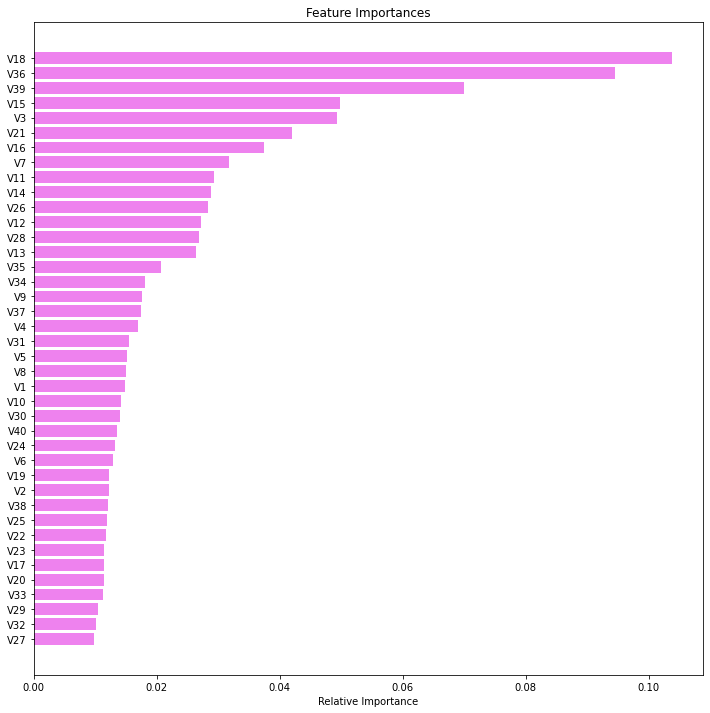

In [64]:
# print feature importance chart

importances = tuned_rf.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Observation: We're still seeing a slight overfit on the training data with the recall score there being 0.980 and the recall score on the validation data being 0.892. 

The most important feature in this model is V18.

### Hyperparameter tuning for Gradient Boost model with undersampled data

In [65]:
%%time

# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {"n_estimators": np.arange(100,150,25),
              "learning_rate": [0.2, 0.05, 1], 
              "subsample":[0.5,0.7],
              "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.2} with CV score=0.9014212538777866:
CPU times: user 1.63 s, sys: 54.3 ms, total: 1.69 s
Wall time: 48.5 s


In [66]:
# Creating new pipeline with best parameters
tuned_gb = GradientBoostingClassifier(
    subsample= 0.5, n_estimators= 100, max_features= 0.7, learning_rate= 0.2
)

tuned_gb.fit(X_train_un, y_train_un)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.7, subsample=0.5)

In [67]:
# check performance on training set
gb_train_perf = model_performance_classification_sklearn(tuned_gb, X_train_un, y_train_un)
gb_train_perf

,Accuracy,Recall,Precision,F1
0,0.989,0.983,0.994,0.989


In [68]:
# check performance on validation set
gb_val_perf = model_performance_classification_sklearn(tuned_gb, X_val, y_val)
gb_val_perf

,Accuracy,Recall,Precision,F1
0,0.914,0.878,0.380,0.530


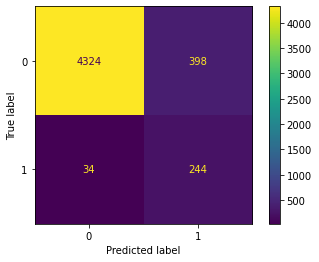

In [69]:
# print confusion matrix on validation set

predictions = tuned_gb.predict(X_val)
cm = confusion_matrix(y_val, predictions, labels=tuned_gb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_gb.classes_)
disp.plot()
plt.show()

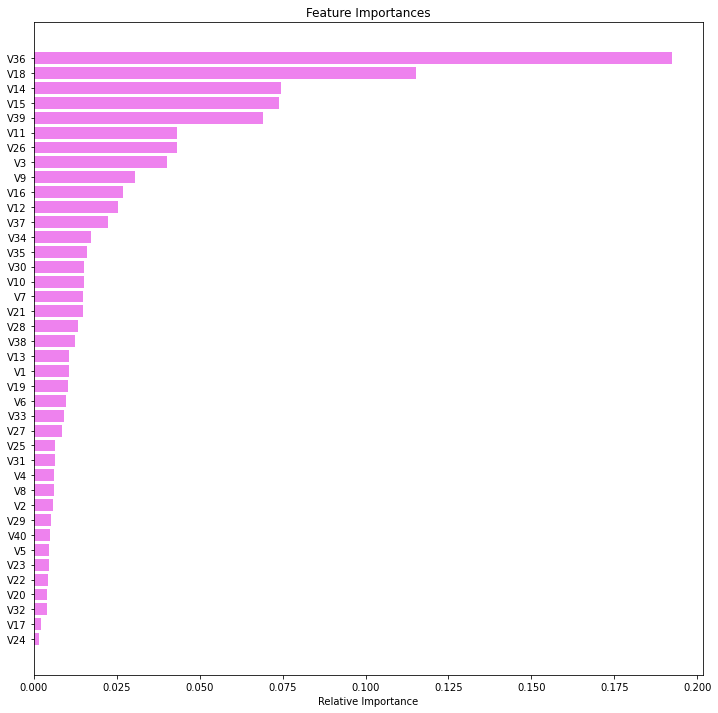

In [70]:
# print feature importance chart

importances = tuned_gb.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Observation: Again, we see a slight overfit on the training data with the recall score there being 0.983 and the recall score on the validation data being 0.878.

The most important feature in this model is V36.

## Model performance comparison and choosing the final model

In [71]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        adaboost_train_perf.T,
        rf_train_perf.T,
        gb_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "AdaBoost classifier tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Gradient boost tuned with undersampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,AdaBoost classifier tuned with oversampled data,Random forest tuned with undersampled data,Gradient boost tuned with undersampled data
Accuracy,0.992,0.989,0.989
Recall,0.988,0.980,0.983
Precision,0.995,0.999,0.994
F1,0.992,0.989,0.989


In [72]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [
        adaboost_val_perf.T,
        rf_val_perf.T,
        gb_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "AdaBoost classifier tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Gradient boost tuned with undersampled data",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,AdaBoost classifier tuned with oversampled data,Random forest tuned with undersampled data,Gradient boost tuned with undersampled data
Accuracy,0.979,0.943,0.914
Recall,0.853,0.892,0.878
Precision,0.790,0.494,0.380
F1,0.820,0.636,0.530


The Random Forest tuned with undersampled data seems to give us the highest recall score on the validation set, and also seems to be overfitting on the training set less than the others. We will select that as our final model.

### Test set final performance

In [73]:
# Calculating different metrics on the test set
rf_test_perf = model_performance_classification_sklearn(tuned_rf, X_test, y_test)
print("Test performance:")
rf_test_perf

Test performance:


,Accuracy,Recall,Precision,F1
0,0.943,0.879,0.499,0.637


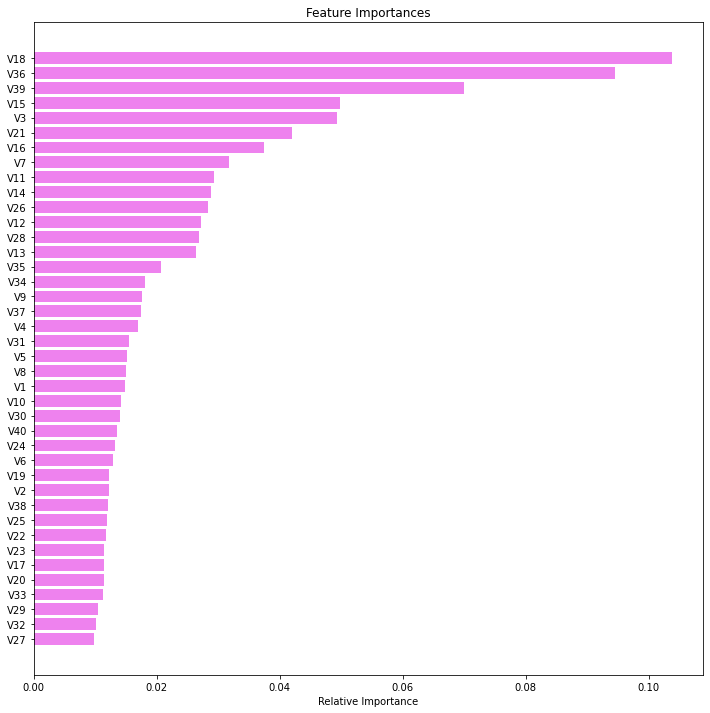

In [74]:
feature_names = X.columns
importances = tuned_rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Pipelines to build the final model


In [75]:
# creating a list of numerical variables
numerical_features = [
    "V1",
    "V2",
    "V3",
    "V4",
    "V5",
    "V6",
    "V7",
    "V8",
    "V9",
    "V10",
    "V11",
    "V12",
    "V13",
    "V14",
    "V15",
    "V16",
    "V17",
    "V18",
    "V19",
    "V20",
    "V21",
    "V22",
    "V23",
    "V24",
    "V25",
    "V26",
    "V27",
    "V28",
    "V29",
    "V30",
    "V31",
    "V32",
    "V33",
    "V34",
    "V35",
    "V36",
    "V37",
    "V38",
    "V39",
    "V40",
]

# creating a transformer for numerical variables, which will apply simple imputer on the numerical variables
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

# using a column transformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
    ],
    remainder="passthrough",
)
# remainder = "passthrough" has been used, it will allow variables that are present in original data 


In [76]:
# Separating target variable and other variables
X_pipe = df.drop(columns="Target")
Y_pipe = df["Target"]

In [77]:
X_test_pipe = df_test.drop(columns='Target')
y_test_pipe = df_test['Target']

In [78]:
# We can't oversample/undersample data without doing missing value treatment, so let's first treat the missing values in the train set
imputer = SimpleImputer(strategy="median")
X_pipe = imputer.fit_transform(X_pipe)

# We don't need to impute missing values in test set as it will be done inside pipeline

In [79]:
# Under Sampling Technique

rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [80]:
# Creating new pipeline with best parameters
model = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "RF",
            RandomForestClassifier(
            n_estimators=250,
            min_samples_leaf= 1,
            max_samples=0.6,
            max_features='sqrt',
        ),
        ),
    ]
)
# Fit the model on training data
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21',
                                                   'V22', 'V23', 'V24', 'V25',
                                                   'V26', 'V27', 'V28', 'V29',
                                                   'V30', ...])])),
                ('RF',
                 RandomForestClassifier(max_samples=0.6, n_estimators=250))])

In [81]:
# Calculating final model performance on the test set
rf_final_test_perf = model_performance_classification_sklearn(model, X_test, y_test)
print("Final model test performance:")
rf_final_test_perf

Final model test performance:


,Accuracy,Recall,Precision,F1
0,0.981,0.674,0.979,0.798


# Business Insights and Conclusions

Our model still seems to be overfitting a bit on the training set and we are only getting a recall score of .674 on the test set. I would recommend we spend more time tuning the hyperparameters to get a better model before we put this into production.

But with this final model, V18, V36, & V39 look to be the most significant features in predicting failure. I would recommmend (if we can, and it's not against security regulations) understanding what those sensors measure to see if we see a pattern and can combine the results with business intuition to determine a collective root cause.

***

In [83]:
%%shell
jupyter nbconvert --to html /content/KD_MT_Project_LearnerNotebook_FullCode.ipynb

[NbConvertApp] Converting notebook /content/KD_MT_Project_LearnerNotebook_FullCode.ipynb to html
[NbConvertApp] Writing 1774985 bytes to /content/KD_MT_Project_LearnerNotebook_FullCode.html
